-----------------
# CSA rates for a axially symmetric diffusion tensor, "model free" approach to treat fast dynamics
-----------------

## Imports, constants, plot parameters

In [1]:
import numpy as np
import pandas as pd
from scipy import constants as cnst
import math
import re
import os
from scipy.optimize import fsolve
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import matplotlib as mpl



#pathos multiprocessing can serialize better than multiprocessing
from pathos.multiprocessing import ProcessingPool as pool

In [8]:
params = {'legend.fontsize': 14,
        'figure.figsize': (10, 8),
        'axes.labelsize': 20,
        'axes.titlesize': 20,
        'xtick.labelsize':16,
        'ytick.labelsize':16,
        "text.usetex": True,
        "font.family": "Helvetica"}

mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

plt.rcParams.update(params)

In [3]:
gammaF = 251.815*1E6 #/ (2 * cnst.pi) # rad s-1 T-1

## Functions

In [4]:
def xb(cL, cR, KD):
    frac = 1 / (2 * cL) * ((cL + cR + KD) - np.sqrt((cL + cR + KD)**2 - 4 * cL * cR)) 
    return frac

def KD(xb, cL, cR):
    K = (cR - cL * xb) * (1 - xb) * cL / (cL * xb)
    return K

In [5]:
def tau_0(Dxy):
    return 1 / (6*Dxy)

def tau_1(Dz, Dxy):
    return 1 / (Dz + 5 * Dxy)

def tau_2(Dz, Dxy):
    return 1 / (4 * Dz + 2 * Dxy)

def tau_n_p(tau_n, tau_i):
    return tau_n * tau_i / (tau_n + tau_i)


def J(tau_n, tau_n_p, omega, S2):
    """
    S2 ... order parameter squared !
    """
    J = 2 * (
            S2 * tau_n / (1 + (omega * tau_n)**2) +
            (1 - S2) * tau_n_p / (1 + (omega * tau_n_p)**2)
            )
    return J

def c0(beta, gamma, eta):
    c =  1/4 * (
            ((3 * np.cos(beta)**2 - 1) + 
            eta * np.sin(beta)**2 * np.cos(2*gamma))**2
            )
    return c

def c1(beta, gamma, eta):
    c =  1/3 * np.sin(beta)**2 * (
            np.cos(beta)**2 * (3 - eta * np.cos(2 * gamma))**2 + 
            eta**2 * np.sin(2*gamma)**2
            )
    return c

    

def c2(beta, gamma, eta):
    
    c =  1 * ( 
            (
            np.sqrt(3/4) * np.sin(beta)**2 +
            eta/(2 * np.sqrt(3)) * (1 + np.cos(beta)**2) * np.cos(2*gamma)          
            )**2 + 
            eta**2 / 3 * np.sin(2*gamma)**2 * np.cos(beta)**2
            )  
    return c
    


def R2CSA(gamma, B0, delta_sigma, Dz, Dxy, tau_i, S2, c0, c1, c2):
    omega = gamma * B0

    R2 = (
        1/40 * gamma**2 * B0**2 * (delta_sigma * 1E-6)**2 * 
            (
                c0 * ( 3 * 
                      J(
                          tau_0(Dxy), 
                          tau_n_p(
                                 tau_0(Dxy),
                                  tau_i
                                 ), 
                          omega, S2
                        ) + 
                      4 * 
                      J(
                          tau_0(Dxy), 
                          tau_n_p(
                                tau_0(Dxy),
                                tau_i
                                  ), 
                          0, S2
                       ) 
                     ) +
                c1 * ( 3 * 
                      J(
                          tau_1(Dz,Dxy), 
                          tau_n_p(
                                  tau_1(Dz,Dxy), 
                                  tau_i
                                  ), 
                          omega, S2
                       ) + 
                      4 * 
                      J(
                          tau_1(Dz,Dxy), 
                          tau_n_p(
                              tau_1(Dz,Dxy),
                              tau_i
                              ), 
                          0, S2
                      )
                      ) +
                c2 * ( 3 * 
                      J(
                          tau_2(Dz,Dxy), 
                          tau_n_p(
                              tau_2(Dz,Dxy), 
                              tau_i
                              ), 
                          omega, S2
                      ) + 
                      4 * 
                      J(
                          tau_2(Dz,Dxy), 
                          tau_n_p(
                              tau_2(Dz,Dxy),
                              tau_i
                              ), 
                          0, S2
                      )
                     )
            )
        )
    return R2

def deltaR2CSA(gamma, B02, B01, delta_sigma, Dz, Dxy, tau_i, S2, c0, c1, c2):
    delta = (
        R2CSA(gamma, B02, delta_sigma, Dz, Dxy, tau_i, S2, c0, c1, c2) -
        R2CSA(gamma, B01, delta_sigma, Dz, Dxy, tau_i, S2, c0, c1, c2)
            )
    return delta


def calcDz(aniso, D):
    # D = Dx + Dy + Dz
    # Dx = Dy
    # aniso = 2 Dz / (Dx + Dy)
    return D/(2*(1/aniso + 1/2))

def calcDxy(aniso, D):
    # D = Dx + Dy + Dz
    # Dx = Dy
    # aniso = 2 Dz / (Dx + Dy)
    return (D - calcDz(aniso, D))/2

def calculateCSAKD(cMolecule, cReceptor, B01, B02, delta_sigma, eta, Dz, Dxy, tau_i, 
                  beta_max, gamma_max, S2min, S2max, n_samples, deltaR2CSAexp, deltaR2CSAexp_free, multiprocessing=True, mp_pool=8):
    
    """calculates KD CSAKD 
    for a range of S2, beta and gamma values
    
    Args:
        cMolecule
        cReceptor
        B01
        B02
        delta_sigma
        eta
        Dz
        Dxy
        tau_i
        beta_max
        gamma_max
        S2min
        S2max
        n_samples
        deltaR2CSAexp
        deltaR2CSAexp_free
        multiprocessing
        mp_pool
        

    Return:
        KD_samples
        
    """
    
    S2_samples = np.random.uniform(S2min, S2max, n_samples)
    u = np.random.uniform(0, 1, n_samples)
    beta_samples = np.arccos(2 * u - 1)  # Sample beta with a distribution proportional to sin(beta)
    #beta_samples = np.random.uniform(0, beta_max, n_samples) 
    gamma_samples = np.random.uniform(0, gamma_max, n_samples) # ensure uniform sampling of diffusion tensor surface !

    
    
    KD_S2_beta_gamma = (
    lambda KD_fit, S2, beta, gamma: np.sqrt((
                KD_fit - 
                KD(
                    (deltaR2CSAexp - deltaR2CSAexp_free)/(
                        deltaR2CSA(
                            gammaF, 
                            B01, 
                            B02, 
                            delta_sigma, 
                            Dz, 
                            Dxy, 
                            tau_i, 
                            S2, 
                            c0(beta, gamma, eta), 
                            c1(beta, gamma, eta), 
                            c2(beta, gamma, eta)
                          )), 
                     cMolecule, 
                     cReceptor
                 )
              )**2)
        )

    def find_min_x(S2, beta, gamma):
        result = minimize_scalar(KD_S2_beta_gamma, args=(S2, beta, gamma))
        return result.x if result.success else None
    
    #x_samples = [find_min_x(KD_expt_sample) for KD_expt_sample in y_samples if find_min_x(KD_expt_sample) is not None]
    

    if multiprocessing == True:
        p = pool(mp_pool) # more than 5 pools does not result in a speedup
        #KD_samples = p.map(find_min_x, zip(S2_samples, beta_samples, gamma_samples))
        KD_samples = p.map(find_min_x, S2_samples, beta_samples, gamma_samples)

    else:
        KD_samples = [
        find_min_x(S2, beta, gamma)
        for S2, beta, gamma in zip(S2_samples, beta_samples, gamma_samples)
        if find_min_x(S2, beta, gamma) is not None
        ]

    
    KD_mean = np.mean(KD_samples)
    KD_std = np.std(KD_samples)
    #print(f"Estimated KD: {x_mean:.4f} ± {x_std:.4f}")
    #print(f"S2: {S2min:.2f} ... {S2max:.2f}")
    #print(f"beta: {0:.2f} ... {beta_max:.2f}")
    #print(f"gamma: {0:.2f} ... {gamma_max:.2f}")
    return KD_samples, np.mean(KD_samples), np.std(KD_samples)

## Simulate deltaR2SCSA = f(beta, gamma, S2)

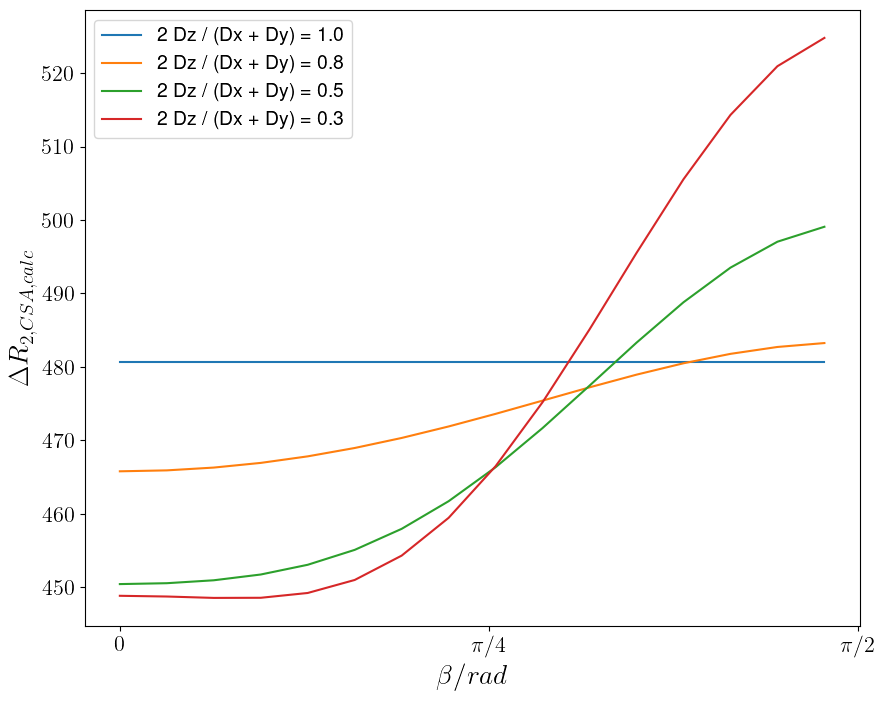

<Figure size 1000x800 with 0 Axes>

In [47]:
B01 = 16.4
B02 = 11.75


delta_sigma = 69.5 # average CF library
eta = 0.998 # average for CF library
D = 3 * 0.25E7 # Dx + Dy + Dz
tau_i = 1E-12
aniso = 0.8

S2 = 0.675
beta = np.radians(54)
gamma = np.radians(54)

aniso_range = np.array([1.0, 0.8, 0.5, 0.3])
beta_range = np.arange(0, np.pi/2, 0.1)
gamma_range = np.arange(0, np.pi/2, 0.1)
S2_range = np.arange(0.0, 1.0, 0.01)
tau_i_range = np.arange(1E-13, 1E-8,10*1E-12)

DR2 = (
        lambda beta, gamma, aniso, S2, tau_i: deltaR2CSA(gammaF, 
               B01, 
               B02, 
               delta_sigma, 
               calcDz(aniso, D), 
               calcDxy(aniso, D), 
               tau_i, 
               S2, 
               c0(beta, gamma, eta), 
               c1(beta, gamma, eta), 
               c2(beta, gamma, eta)
              )
        )


fig = plt.figure()
ax  = fig.add_subplot(111)

for aniso in aniso_range:
    plt.plot(beta_range, DR2(beta_range, gamma, aniso, S2, tau_i), label="2 Dz / (Dx + Dy) = %s"%aniso)


plt.legend()
plt.xlabel(r'\textbf{$\beta / rad$}')
plt.ylabel(r'\textbf{$\Delta R_{2,CSA,calc}$')
#plt.ylim(0, 180)

x_pi   = gamma_range/np.pi
unit   = 0.25
x_tick = np.arange(0, 0.5+unit, unit)

x_label = [r"$0$", r"$ \pi / 4$", r"$ \pi / 2$"]
ax.set_xticks(x_tick*np.pi)
ax.set_xticklabels(x_label)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("/home/Simon/Documents/BNSP/projects/FBS/publication/deltaR2CSA_vs_beta.png", dpi=300)

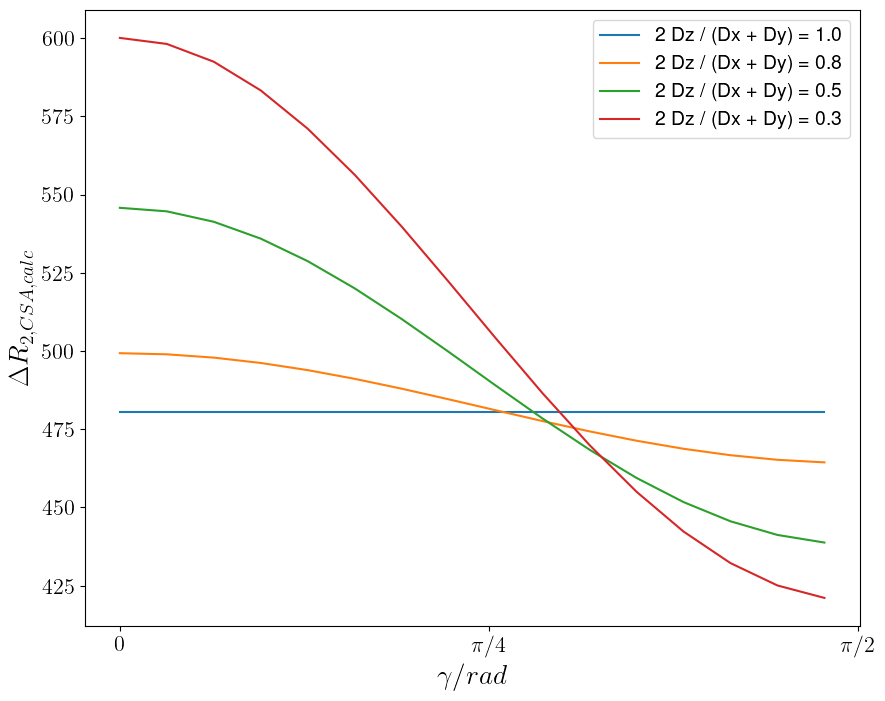

<Figure size 1000x800 with 0 Axes>

In [22]:
fig = plt.figure()
ax  = fig.add_subplot(111)

for aniso in aniso_range:
    plt.plot(gamma_range, DR2(beta, gamma_range, aniso, S2, tau_i), label="2 Dz / (Dx + Dy) = %s"%aniso)


plt.legend()
plt.xlabel(r'\textbf{$\gamma / rad$}')
plt.ylabel(r'\textbf{$\Delta R_{2,CSA,calc}$')
#plt.ylim(0, 180)

x_pi   = gamma_range/np.pi
unit   = 0.25
x_tick = np.arange(0, 0.5+unit, unit)

x_label = [r"$0$", r"$ \pi / 4$", r"$ \pi / 2$"]
ax.set_xticks(x_tick*np.pi)
ax.set_xticklabels(x_label)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("/home/Simon/Documents/BNSP/projects/FBS/publication/deltaR2CSA_vs_gamma.png", dpi=300)

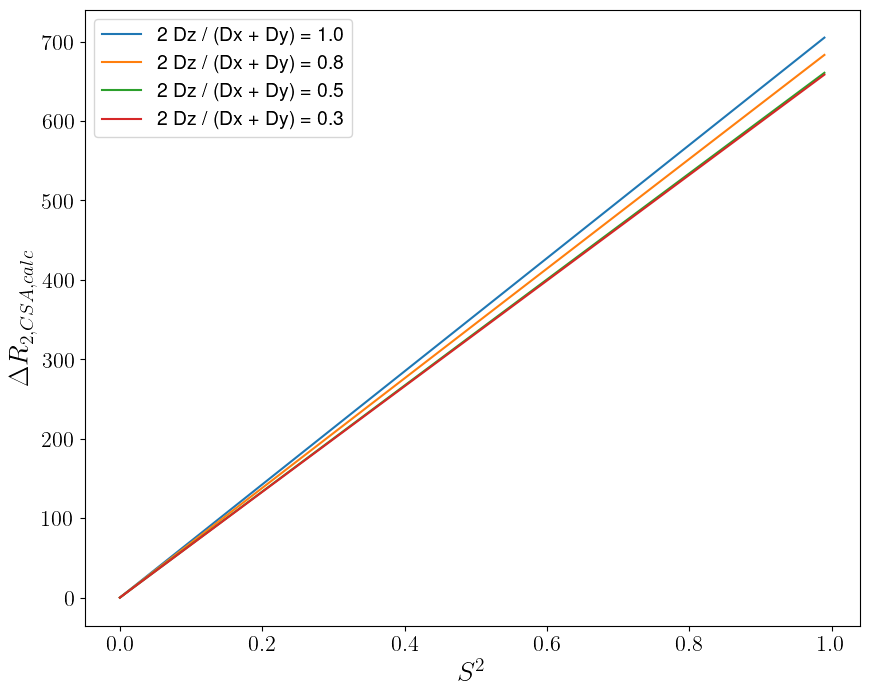

<Figure size 1000x800 with 0 Axes>

In [36]:
beta = np.radians(0)
gamma = np.radians(0)

fig = plt.figure()
ax  = fig.add_subplot(111)

for aniso in aniso_range:
    plt.plot(S2_range, DR2(beta, gamma, aniso, S2_range, tau_i), label="2 Dz / (Dx + Dy) = %s"%aniso)


plt.legend()
plt.xlabel(r'\textbf{$S^2$}')
plt.ylabel(r'\textbf{$\Delta R_{2,CSA,calc}$')
#plt.ylim(0, 180)



fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("/home/Simon/Documents/BNSP/projects/FBS/publication/deltaR2CSA_vs_S2.png", dpi=300)

In [44]:
DR2(beta, gamma, aniso, S2, tau_i_range[0])

479.29644595991806

In [45]:
tau_i_range

array([1.000e-13, 1.010e-11, 2.010e-11, 3.010e-11, 4.010e-11, 5.010e-11,
       6.010e-11, 7.010e-11, 8.010e-11, 9.010e-11, 1.001e-10, 1.101e-10,
       1.201e-10, 1.301e-10, 1.401e-10, 1.501e-10, 1.601e-10, 1.701e-10,
       1.801e-10, 1.901e-10, 2.001e-10, 2.101e-10, 2.201e-10, 2.301e-10,
       2.401e-10, 2.501e-10, 2.601e-10, 2.701e-10, 2.801e-10, 2.901e-10,
       3.001e-10, 3.101e-10, 3.201e-10, 3.301e-10, 3.401e-10, 3.501e-10,
       3.601e-10, 3.701e-10, 3.801e-10, 3.901e-10, 4.001e-10, 4.101e-10,
       4.201e-10, 4.301e-10, 4.401e-10, 4.501e-10, 4.601e-10, 4.701e-10,
       4.801e-10, 4.901e-10, 5.001e-10, 5.101e-10, 5.201e-10, 5.301e-10,
       5.401e-10, 5.501e-10, 5.601e-10, 5.701e-10, 5.801e-10, 5.901e-10,
       6.001e-10, 6.101e-10, 6.201e-10, 6.301e-10, 6.401e-10, 6.501e-10,
       6.601e-10, 6.701e-10, 6.801e-10, 6.901e-10, 7.001e-10, 7.101e-10,
       7.201e-10, 7.301e-10, 7.401e-10, 7.501e-10, 7.601e-10, 7.701e-10,
       7.801e-10, 7.901e-10, 8.001e-10, 8.101e-10, 

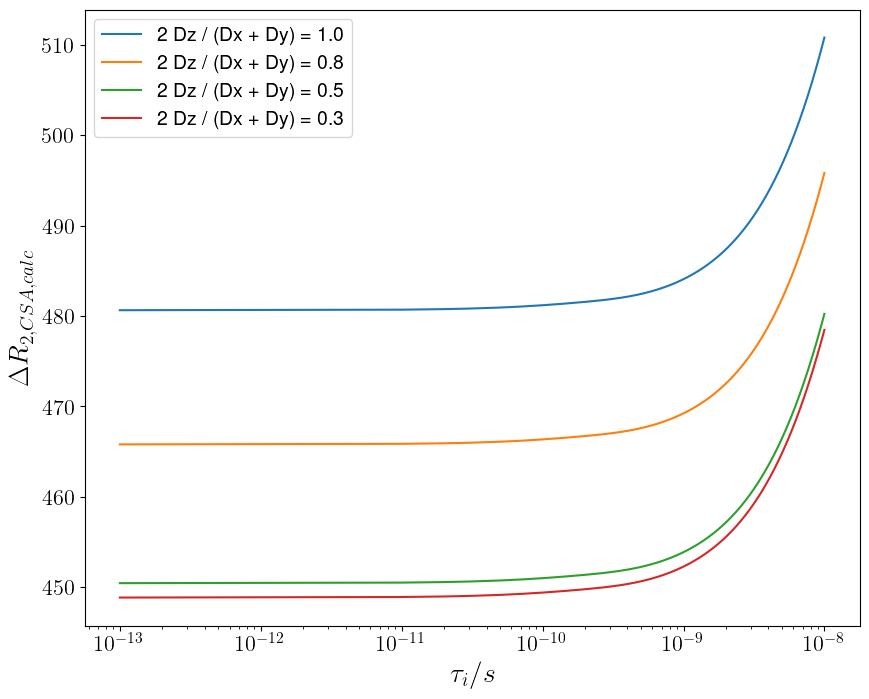

<Figure size 1000x800 with 0 Axes>

In [49]:
beta = np.radians(0)
gamma = np.radians(0)

fig = plt.figure()
ax  = fig.add_subplot(111)

for aniso in aniso_range:
    plt.semilogx(tau_i_range, DR2(beta, gamma, aniso, S2, tau_i_range), label="2 Dz / (Dx + Dy) = %s"%aniso)


plt.legend()
plt.xlabel(r'\textbf{$\tau_i / s$}')
plt.ylabel(r'\textbf{$\Delta R_{2,CSA,calc}$')
#plt.ylim(0, 180)



fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("/home/Simon/Documents/BNSP/projects/FBS/publication/deltaR2CSA_vs_tau_i.png", dpi=300)

## Calculate the KD for simulated R2CSA 

### Symmetric diffusion tensor: parameters

In [42]:
# B0 field
B01 = 16.4
B02 = 11.75

# 19F CSA, diffusion tensor, S2, tau_i bound state
delta_sigma = 43.52 # average CF3 library
eta = 0 # CF3
beta = math.radians(54.7) # magic angle
gamma = math.radians(54.7)
D = 3 * 0.25*1E7 # Dx + Dy + Dz
aniso = 0.8
tau_i = 1E-12
S2 = 0.675 #0.725

# concentration and affinities
cMolecule = 100
cReceptor = 10
KDligand = 100
deltaR2CSAexp_free = 0.1

xbound = xb(cMolecule, cReceptor, KDligand)

# search parameters for fitting the KD values
beta_max = math.radians(90)
gamma_max = math.radians(90)
S2min = 0.5
S2max = 0.85
n_samples = 20**3 # number of samples n(beta) = n(gamma) = n(S2) to sample


aniso_range = [1.0, 0.8, 0.5]
n_samples_simulate = 4**3 # number of samples n(beta) = n(gamma) = n(S2)  to simulate 


# for each anisotropy, create range of beta, gamma and S2 values

#aniso_samples = np.array([[i] * n_samples_simulate for i in aniso_range]).flatten()

u = np.random.uniform(0, 1, n_samples_simulate)
#beta_samples = np.repeat(np.arccos(2 * u - 1), len(aniso_range))  # Sample beta with a distribution proportional to sin(beta)
#gamma_samples = np.repeat(np.random.uniform(0, gamma_max, n_samples_simulate), len(aniso_range)) # ensure uniform sampling of diffusion tensor surface !
#S2_samples = np.repeat(np.random.uniform(S2min, S2max, n_samples_simulate), len(aniso_range))

beta_samples = np.arccos(2 * u - 1)  # Sample beta with a distribution proportional to sin(beta)
gamma_samples = np.random.uniform(0, gamma_max, n_samples_simulate) # ensure uniform sampling of diffusion tensor surface !
S2_samples = np.random.uniform(S2min, S2max, n_samples_simulate)

In [39]:
len(list(zip(beta_samples, gamma_samples,S2_samples)))

8

mean: 100.65853005700652
std: 30.725995278256207
nr. KDs: 8000


(array([0.00158939, 0.0044829 , 0.00841563, 0.00866015, 0.01020879,
        0.00957711, 0.01053482, 0.00992352, 0.00943447, 0.00886392,
        0.00906769, 0.01012728, 0.01004578, 0.00878241, 0.00998465,
        0.0092307 , 0.00912882, 0.00690775, 0.00529798, 0.00275087]),
 array([ 39.23078452,  45.36520272,  51.49962093,  57.63403914,
         63.76845735,  69.90287555,  76.03729376,  82.17171197,
         88.30613017,  94.44054838, 100.57496659, 106.7093848 ,
        112.843803  , 118.97822121, 125.11263942, 131.24705762,
        137.38147583, 143.51589404, 149.65031225, 155.78473045,
        161.91914866]),
 [<matplotlib.patches.Polygon at 0x7f84d4329420>])

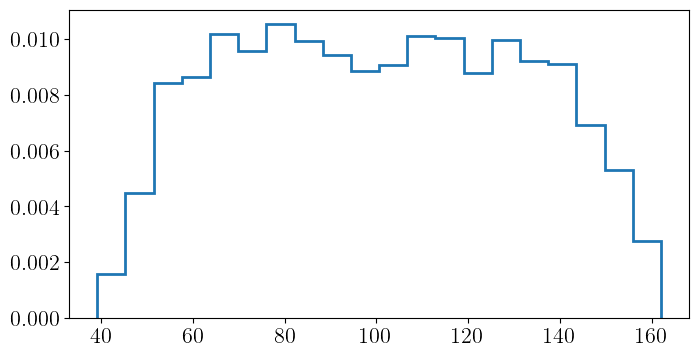

In [23]:
# testing for theoretical deltaR2CSAexp
deltaR2CSAexp = (
                xbound * deltaR2CSA(gammaF, B01, B02, delta_sigma, calcDz(aniso, D), calcDxy(aniso, D), tau_i, S2, 
               c0(beta, gamma, eta), 
               c1(beta, gamma, eta), 
               c2(beta, gamma, eta))  
                + (1 - xbound) * deltaR2CSAexp_free
                )

KDs = calculateCSAKD(cMolecule, cReceptor, B01, B02, delta_sigma, eta, calcDz(aniso, D), calcDxy(aniso, D), tau_i, 
                  beta_max, gamma_max, S2min, S2max, n_samples, deltaR2CSAexp, deltaR2CSAexp_free, multiprocessing=True)

print("mean: " + str(np.mean(KDs[0])))
print("std: " + str(np.std(KDs[0])))
print("nr. KDs: " + str(len(KDs[0])))
plt.hist(KDs[0], histtype="step", density=True, bins=20, label="2 Dz / (Dx + Dy) = %s"%aniso, linewidth=2)

In [17]:
# %timeit -n 10 -r 3  calculateCSAKD(cMolecule, cReceptor, B01, B02, delta_sigma, eta, calcDz(aniso, D), calcDxy(aniso, D), tau_i, beta_max, gamma_max, S2min, S2max, n_samples, deltaR2CSAexp, deltaR2CSAexp_free, multiprocessing=True, mp_pool=2)

In [18]:
# %timeit -n 10 -r 3  calculateCSAKD(cMolecule, cReceptor, B01, B02, delta_sigma, eta, calcDz(aniso, D), calcDxy(aniso, D), tau_i, beta_max, gamma_max, S2min, S2max, n_samples, deltaR2CSAexp, deltaR2CSAexp_free, multiprocessing=True, mp_pool=4)

In [59]:
# %timeit -n 10 -r 3  calculateCSAKD(cMolecule, cReceptor, B01, B02, delta_sigma, eta, calcDz(aniso, D), calcDxy(aniso, D), tau_i, beta_max, gamma_max, S2min, S2max, n_samples, deltaR2CSAexp, deltaR2CSAexp_free, multiprocessing=True, mp_pool=8)
# pool = 8 about 3x faster than pool = 2

1.83 s ± 23 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [43]:
# calculate KDs for a theoretical KD = 100 uM for various diffusion tensor anisotropies, for each anisotropy a range of S2, beta, gamma

KDfit_aniso = {}

for aniso in aniso_range:
    KDfit_aniso[aniso] = []
    
    KD_aniso = (lambda aniso: calculateCSAKD(
        cMolecule,
        cReceptor,
        B01,
        B02,
        delta_sigma,
        eta,
        calcDz(aniso, D),
        calcDxy(aniso, D),
        tau_i,
        beta_max,
        gamma_max,
        S2min,
        S2max,
        n_samples,
        deltaR2CSAexp,
        deltaR2CSAexp_free)[0])

    for beta, gamma, S2 in zip(beta_samples, gamma_samples,S2_samples):
        deltaR2CSAexp = (
                xbound * deltaR2CSA(gammaF, B01, B02, delta_sigma, calcDz(aniso, D), calcDxy(aniso, D), tau_i, S2, 
               c0(beta, gamma, eta), 
               c1(beta, gamma, eta), 
               c2(beta, gamma, eta))  
                + (1 - xbound) * deltaR2CSAexp_free
            )
        KDfit_aniso[aniso] = KDfit_aniso[aniso] + (KD_aniso(aniso))

np.save("KD_beta_gamma_S2_symmetric.npy", KDfit_aniso)

anisotropy: 1.0
KD mean = 100.99941307171349
KD std = 42.47549988518888
anisotropy: 0.8
KD mean = 101.391998028475
KD std = 43.551569818441926
anisotropy: 0.5
KD mean = 103.28112409030471
KD std = 51.58164077304611


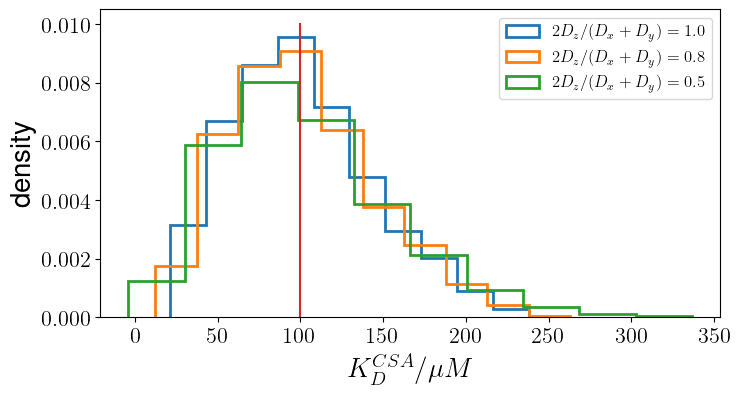

In [44]:
KDfit_aniso = np.load("KD_beta_gamma_S2_symmetric.npy", allow_pickle=True)


for aniso in aniso_range:
    KD_all = KDfit_aniso.item().get(aniso)
    plt.hist(KD_all, histtype="step", density=True, label=r'\textbf{$2 D_z / (D_x + D_y) = %s$}'%aniso, linewidth=2)
    print("anisotropy: " + str(aniso))
    print("KD mean = " + str(np.mean(KD_all)))
    print("KD std = " + str(np.std(KD_all)))

plt.plot([100, 100],[0, 0.01])
plt.xlabel(r'\textbf{${K}_{D}^{CSA}/{\mu M}$}')
plt.ylabel("density")
plt.legend(fontsize=12)
plt.savefig("/home/Simon/Documents/BNSP/projects/FBS/publication/KD_beta_gamma_S2_symmetric.svg")

### Asymmetric diffusion tensor: parameters

In [45]:
# B0 field
B01 = 16.4
B02 = 11.75

# 19F CSA, diffusion tensor, S2, tau_i bound state
delta_sigma = 69.5 # average CF library
eta = 0.998 # average for CF library
beta = math.radians(54.7)
gamma = math.radians(54.7)
D = 3 * 0.25*1E7 # Dx + Dy + Dz
aniso = 0.8
tau_i = 1E-12
S2 = 0.675 #0.725

# experimental conditions
cMolecule = 100
cReceptor = 10
KDligand = 100
deltaR2CSAexp_free = 0.1

xbound = xb(cMolecule, cReceptor, KDligand)


# search parameters
beta_max = math.radians(90)
gamma_max = math.radians(90)
S2min = 0.5
S2max = 0.85
n_samples = 20**3 # number of samples n(beta) = n(gamma) = n(S2) to sample


aniso_range = [1.0, 0.8, 0.5]
n_samples_simulate = 4**3 # number of samples n(beta) = n(gamma) = n(S2)  to simulate 

# for each anisotropy, create range of beta, gamma and S2 values

aniso_samples = np.array([[i] * n_samples_simulate for i in aniso_range]).flatten()

u = np.random.uniform(0, 1, n_samples_simulate)
beta_samples = np.repeat(np.arccos(2 * u - 1), len(aniso_range))  # Sample beta with a distribution proportional to sin(beta)
gamma_samples = np.repeat(np.random.uniform(0, gamma_max, n_samples_simulate), len(aniso_range)) # ensure uniform sampling of diffusion tensor surface !
S2_samples = np.repeat(np.random.uniform(S2min, S2max, n_samples_simulate), len(aniso_range))

In [46]:
# calculate KDs for a theoretical KD = 100 uM for various diffusion tensor anisotropies, for each anisotropy a range of S2, beta, gamma

KDfit_aniso = {}

for aniso in aniso_range:
    KDfit_aniso[aniso] = []

    KD_aniso = (lambda aniso: calculateCSAKD(
        cMolecule,
        cReceptor,
        B01,
        B02,
        delta_sigma,
        eta,
        calcDz(aniso, D),
        calcDxy(aniso, D),
        tau_i,
        beta_max,
        gamma_max,
        S2min,
        S2max,
        n_samples,
        deltaR2CSAexp,
        deltaR2CSAexp_free)[0])

    for beta, gamma, S2 in zip(beta_samples, gamma_samples,S2_samples):
        deltaR2CSAexp = (
                xbound * deltaR2CSA(gammaF, B01, B02, delta_sigma, calcDz(aniso, D), calcDxy(aniso, D), tau_i, S2, 
               c0(beta, gamma, eta), 
               c1(beta, gamma, eta), 
               c2(beta, gamma, eta))  
                + (1 - xbound) * deltaR2CSAexp_free
            )
        KDfit_aniso[aniso] = KDfit_aniso[aniso] + (KD_aniso(aniso))

np.save("KD_beta_gamma_S2_asymmetric.npy", KDfit_aniso)

anisotropy: 1.0
KD mean = 105.78599442295585
KD std = 43.846128838340796
anisotropy: 0.8
KD mean = 105.24194688298431
KD std = 45.01214616569561
anisotropy: 0.5
KD mean = 105.66758640934238
KD std = 52.921073533884446


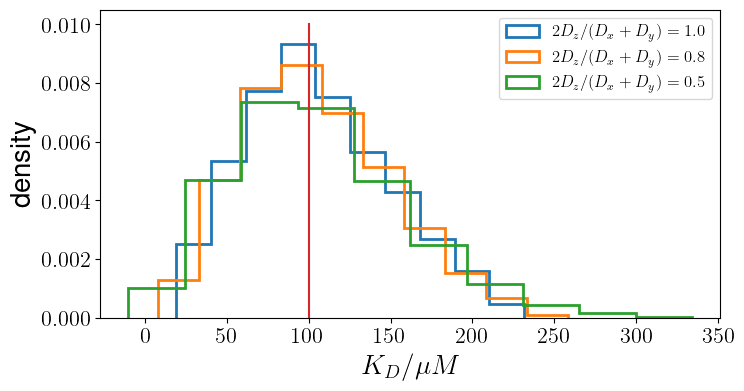

In [47]:
KDfit_aniso = np.load("KD_beta_gamma_S2_asymmetric.npy", allow_pickle=True)
KDfit_aniso.item

for aniso in aniso_range:
    plt.hist(KDfit_aniso.item().get(aniso), histtype="step", density=True, label=r'\textbf{$2 D_z / (D_x + D_y) = %s$}'%aniso, linewidth=2)
    print("anisotropy: " + str(aniso))
    print("KD mean = " + str(np.mean(KDfit_aniso.item().get(aniso))))
    print("KD std = " + str(np.std(KDfit_aniso.item().get(aniso))))

plt.plot([100, 100],[0, 0.01])
plt.xlabel(r'\textbf{${K}_{D}/{\mu M}$}')
plt.ylabel("density")
plt.legend(fontsize=12)
plt.savefig("/home/Simon/Documents/BNSP/projects/FBS/publication/KD_beta_gamma_S2_asymmetric.svg")

In [ ]:
###########################################
# Reproduce published data, Hull and Sykes J. Mol. Biol. 1975, Table 2
###########################################

beta = math.radians(90)
gamma = math.radians(30)

B0 = 339/40.078 # 40.078 MHz /-1
delta_sigma = 72.4 
eta = -0.485 
D = 3 * 0.25*1E7 # Dx + Dy + Dz, tau_c =  7E-8 s, D = 1 / (6 * 7 * 1E-8) = 0.025 E8
aniso = 1.0
tau_i = 1E-12
S2 = 1

print(c0(beta, gamma, eta))
print(c1(beta, gamma, eta))
print(c2(beta, gamma, eta))

R2CSA(gammaF, B0, delta_sigma, calcDz(aniso, D), calcDxy(aniso, D), tau_i, S2, c0(beta, gamma, eta), c1(beta, gamma, eta), c2(beta, gamma, eta))


## Read in R2CSA data, concentrations

In [48]:
data = pd.read_excel("../../data/CSARKDdata.xlsx", skiprows=[1])

In [49]:
data.columns

Index(['receptor', 'Dx', 'Dy', 'Dz', 'molecule', 'KD', 'KD_error',
       'delta_sigma', 'eta', 'B01', 'B02', 'deltaR2free', 'deltaR2',
       'cMolecule', 'cReceptor', 'S2', 'tau_i', 'beta', 'gamma'],
      dtype='object')

In [50]:
gammaF = 251.815*1E6 #/ (2 * cnst.pi) # rad s-1 T-1

data["Dxy"] = (data["Dx"] + data["Dy"]) / 2
rad = lambda x: math.radians(x)


data["deltaR2calc"] = (
    deltaR2CSA(gammaF, 
               data["B01"], 
               data["B02"], 
               data["delta_sigma"], 
               data["Dz"]*1E7, 
               data["Dxy"]*1E7, 
               data["tau_i"], 
               data["S2"], 
               c0(data["beta"].map(rad), data["gamma"].map(rad), data["eta"]), 
               c1(data["beta"].map(rad), data["gamma"].map(rad), data["eta"]), 
               c2(data["beta"].map(rad), data["gamma"].map(rad), data["eta"])
              )
)

data["CSARKD"] = KD((data["deltaR2"] - data["deltaR2free"])/data["deltaR2calc"], data["cMolecule"], data["cReceptor"])

In [51]:
data.to_excel("../../data/CSARKDresults.xlsx")

In [52]:
data.columns

Index(['receptor', 'Dx', 'Dy', 'Dz', 'molecule', 'KD', 'KD_error',
       'delta_sigma', 'eta', 'B01', 'B02', 'deltaR2free', 'deltaR2',
       'cMolecule', 'cReceptor', 'S2', 'tau_i', 'beta', 'gamma', 'Dxy',
       'deltaR2calc', 'CSARKD'],
      dtype='object')

In [53]:
print(data[['receptor', 'Dx', 'Dy', 'Dz', 'molecule', 'B01', 'B02', 'deltaR2free', 'deltaR2',
       'cMolecule', 'cReceptor']].to_latex(index=False,
                  float_format="{:.3f}".format,
                  formatters={"tau_i":"{:.2e}".format, "Dx":"{:.4f}".format, "Dy":"{:.4f}".format, "Dz":"{:.4f}".format},
))

\begin{tabular}{lrrrlrrrrrr}
\toprule
receptor & Dx & Dy & Dz & molecule & B01 & B02 & deltaR2free & deltaR2 & cMolecule & cReceptor \\
\midrule
CoaD & 0.2622 & 0.2532 & 0.2555 &  TFL355  & 16.400 & 11.750 & 0.415 & 1.490 & 200 & 5 \\
CoaD & 0.2622 & 0.2532 & 0.2555 &  TFL355  & 16.400 & 11.750 & 0.415 & 1.490 & 200 & 5 \\
CoaD & 0.2622 & 0.2532 & 0.2555 &  COD005  & 16.400 & 11.750 & 0.403 & 0.475 & 200 & 5 \\
CoaD & 0.2622 & 0.2532 & 0.2555 &  COD005  & 16.400 & 11.750 & 0.403 & 0.475 & 200 & 5 \\
Mpro  & 0.2850 & 0.3577 & 0.3930 &  TFL071  & 16.400 & 11.750 & 0.360 & 1.010 & 200 & 30 \\
Mpro  & 0.2850 & 0.3577 & 0.3930 &  TFL071  & 16.400 & 11.750 & 0.360 & 1.010 & 200 & 30 \\
Mpro  & 0.2850 & 0.3577 & 0.3930 &  TRY013  & 16.400 & 11.750 & 0.253 & 0.761 & 200 & 30 \\
Mpro  & 0.2850 & 0.3577 & 0.3930 &  TRY013  & 16.400 & 11.750 & 0.253 & 0.761 & 200 & 30 \\
Abl1  & 0.4070 & 0.4653 & 0.5821 &  ABL002  & 18.800 & 11.750 & 0.601 & 9.170 & 100 & 20 \\
Abl1  & 0.4070 & 0.4653 & 0.5821 & 

In [54]:
print(data[['receptor', 'molecule', 'KD', 'KD_error',
       'delta_sigma', 'eta', 'S2', 'tau_i', 'beta', 'gamma', 
       'deltaR2calc', 'CSARKD']].to_latex(index=False,
                  float_format="{:.1f}".format,
                  formatters={"tau_i":"{:.2e}".format},
))

\begin{tabular}{llrrrrrrrrrr}
\toprule
receptor & molecule & KD & KD_error & delta_sigma & eta & S2 & tau_i & beta & gamma & deltaR2calc & CSARKD \\
\midrule
CoaD &  TFL355  & 437.1 & 66.5 & 42.8 & 0 & 0.7 & 1.00e-12 & 0 & 0 & 137.7 & 436.9 \\
CoaD &  TFL355  & 437.1 & 66.5 & 42.8 & 0 & 0.7 & 1.00e-12 & 90 & 0 & 138.3 & 439.6 \\
CoaD &  COD005  & 598.0 & 364.0 & 23.6 & 0 & 0.7 & 1.00e-12 & 0 & 0 & 41.9 & 2702.2 \\
CoaD &  COD005  & 598.0 & 364.0 & 23.6 & 0 & 0.7 & 1.00e-12 & 90 & 0 & 42.0 & 2714.7 \\
Mpro  &  TFL071  & 3187.0 & 192.0 & 36.4 & 0 & 0.7 & 1.00e-12 & 0 & 0 & 79.9 & 3457.2 \\
Mpro  &  TFL071  & 3187.0 & 192.0 & 36.4 & 0 & 0.7 & 1.00e-12 & 90 & 0 & 72.1 & 3099.7 \\
Mpro  &  TRY013  & 6748.0 & 237.0 & 36.1 & 0 & 0.7 & 1.00e-12 & 0 & 0 & 78.5 & 4409.7 \\
Mpro  &  TRY013  & 6748.0 & 237.0 & 36.1 & 0 & 0.7 & 1.00e-12 & 90 & 0 & 70.9 & 3959.7 \\
Abl1  &  ABL002  & 159.0 & NaN & 36.6 & 0 & 0.7 & 1.00e-12 & 0 & 0 & 97.9 & 117.2 \\
Abl1  &  ABL002  & 159.0 & NaN & 36.6 & 0 & 0.7 & 1

In [56]:
# fit KD for all target - ligand
#receptor = "trypsin"; molecule = "TRY001"

#complex_data = data.loc[((data["receptor"].str.contains(receptor)) & (data["molecule"].str.contains(molecule)))].iloc[2]

beta_max = math.radians(90)
gamma_max = math.radians(90)
S2min = 0.5
S2max = 0.85
n_samples = 20**3

row_lists = []

for receptor, molecule in zip(list(data["receptor"]), list(data["molecule"])):
    
    complex_data = data.loc[((data["receptor"].str.contains(receptor)) & (data["molecule"].str.contains(molecule)))].iloc[0]
    complex_data["KDCSARmean_std"]  = calculateCSAKD(
        complex_data["cMolecule"],
        complex_data["cReceptor"],
        complex_data["B01"],
        complex_data["B02"],
        complex_data["delta_sigma"],
        complex_data["eta"],
        complex_data["Dx"]*1E7,
        complex_data["Dxy"]*1E7,
        complex_data["tau_i"]*1E-12,
        beta_max,
        gamma_max,
        S2min,
        S2max,
        n_samples,
        complex_data["deltaR2"],
        complex_data["deltaR2free"])[1:]
    
    complex_data["KDCSARmean"] = complex_data["KDCSARmean_std"][0]
    complex_data["KDCSARstd"] = complex_data["KDCSARmean_std"][1]
    row_lists.append(complex_data)

df_CSARKD = pd.DataFrame(row_lists)
df_CSARKD[['receptor', 'molecule', 'KD', 'KD_error',
        'KDCSARmean', 'KDCSARstd']]

,receptor,molecule,KD,KD_error,KDCSARmean,KDCSARstd
0,CoaD,TFL355,437.1,66.5,411.009225,91.642231
0,CoaD,TFL355,437.1,66.5,413.386940,91.652257
2,CoaD,COD005,598.0,364.0,2575.530589,415.860176
2,CoaD,COD005,598.0,364.0,2588.445943,415.996266
4,Mpro,TFL071,3187.0,192.0,3460.869654,557.883565
4,Mpro,TFL071,3187.0,192.0,3471.562079,552.719316
6,Mpro,TRY013,6748.0,237.0,4423.007696,700.185848
6,Mpro,TRY013,6748.0,237.0,4415.945764,699.459732
8,Abl1,ABL002,159.0,NaN,114.822674,32.519445
8,Abl1,ABL002,159.0,NaN,114.243347,32.393298
